Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

Before you turn this problem in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All). On JupyterLab, you may want to hit the "Validate" button as well.

Caution: do not mess with the notebook's metadata; do not change a pre-existing cell's type; do not copy pre-existing cells (add new ones with the + button instead). This will break autograding; you will get a 0; you are warned.

<table style="width: 100%; border: none;" cellspacing="0" cellpadding="0" border="0">
  <tr>
    <td><img src="https://www.planetegrandesecoles.com/wp-content/uploads/2021/07/Identite%CC%81-visuelle-Plane%CC%80te-BAC-8-600x398.png" style="float: left; width: 100%" />
</td>
    <td><h1 style="text-align: center; vertical-align: middle;"><a href="https://moodle.polytechnique.fr/course/view.php?id=15585">[CSE204-2022] - Introduction to Machine Learning</a></h1>
</td>
  </tr>
</table>

---

# Lab Session 14: Miscellaneous techniques - generative models & genetic algorithms

Jesse Read, Adrien Ehrhardt

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import multiprocessing
from matplotlib import pyplot as plt

In [2]:
from bokeh.io import output_notebook
from bokeh.models import HoverTool
from bokeh.palettes import viridis
from bokeh.plotting import figure, show

In [3]:
# This is required for bokeh plots to appear in the notebook
output_notebook()

Loading BokehJS ...

## Part 1: Generative Models and Latent Variables (10 pts)

In this part of the lab we will look at generative models, as seen in the lecture. 

### Toy Dataset

Toy dataset: A number of beetles `x`, recording their length in centimeters. A label `y` (either `0` or `1`) indicates the species the beetle belongs to. 

**Task**: Have a look. 

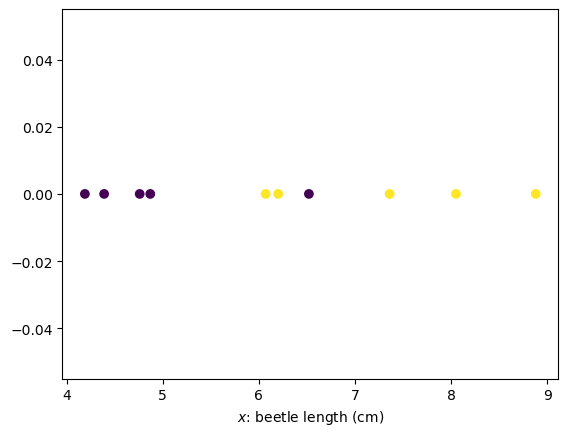

In [4]:
# Beetle lengths (cm)
x = np.array([-0.13,  1.52, -0.81, -0.61, -0.24, 1.07, 2.36, 1.20, 3.88, 3.05]) + 5
# Beetle species id
y = np.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1], dtype=int)  
# Plot it
fig = plt.figure()
plt.scatter(x,np.zeros_like(x),c=y)
plt.xlabel("$x$: beetle length (cm)")
plt.show()

### Gaussian Probabily Density Functions

This is a function we're going to use later: $p(x)$ where $p$ is a 1D density function defined from a Gaussian distribution of mean `m` and standard deviation `s`. And `x` is, e.g., a beetle length in cm.

**Task**: Implement the function.

**Hint**: Use `scipy.stats` if you like (specifically: [`stats.norm.pdf`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html)).

In [5]:
def p(x: float, m: float = 0.0, s: float = 1.0) -> float:
    """
    Gaussian probability density function

    Parameters
    ----------

    x : a float to evaluate the pdf
    m : the mean
    s : the standard deviation

    Return
    ------
    p : relative probability of x wrt gaussian distribution of mean m, std dev s
    """
    # YOUR CODE HERE
    return stats.norm.pdf(x, loc=m, scale=s)

### Gaussian Mixture Models 

You are going to fit a *Gausian Mixture Model* (GMM) to the data `x,y` (that you looked at above), by completing the code below. Essentially you are 'learning' $p(x,y) = p(x | y)p(y)$ via the two components on the right hand side: $p(x|y)$, for which you will assume a 1D Gaussian distribution (i.e., having *parameters* mean `m` and standard deviation `s`); and $p(y)$ for which you will assume a Bernoulli distribution (i.e., having *parameter* `w`, the proportion of class `y`).   

**Task:** provide a *maximum likelihood estimate* of parameters `m`,`s`,`w`, by completing the code below. 

**Hint:** This is a supervised-learning task; there is one set of parameters involved *for each label*.

In [6]:
def fit(x,y):
    """
    Maximum Likelihood Estimaiton.
    
    Estimate the most likely parameters for this data, under the assumption of a Gaussian distribution per label.

    You may assume that the labels are either 0 or 1 (the binary case).
    
    Parameters
    ----------
    
    x : a vector of n samples
    y : a vector of n labels

    Return
    ------
    
    w : a vector of weights, where w[j] represents p(y = j)
    m : a vector of means 
    s : a vector of standard deviations
    """

    n = len(y)
    labels = np.unique(y)
    k = len(labels)
    w = np.zeros(k)
    m = np.zeros(k)
    s = np.zeros(k)   

    # YOUR CODE HERE
    for j in range(k):
        w[j] = np.mean(y == labels[j])
        x_j = x[y == labels[j]]
        m[j] = np.mean(x_j)
        s[j] = np.std(x_j)

    return w, m, s

In [7]:
# Using your code to fit the model (estimate the parameters)
w, m, s = fit(x, y)
print(w, m, s)

[0.5 0.5] [4.946 7.312] [0.82444163 1.07560959]


In [8]:
assert w.shape == m.shape == s.shape == (2, )  # 2 parameters, 1 per label!

### Generative Models for Classification

We can use generative models for classification. 

**Task:** Provide a classification/prediction `yp` (of the same shape and type as `y`) according to your generative model. 

**Hint:** Use your function `p` from above.

*N.B.:* We're breaking a few cardinal rules of ML to make this lab simpler; i.e., don't worry about overfitting or anything here; for the purpose of learning about generative models. 

In [9]:
def pred(x, w, m, s):
    """
    Prediction.
    Predict the labels for this data.
    You may assume that the labels in y are either 0 or 1 (the binary case).

    Parameters
    ----------

    x : a vector of n samples
    w : a vector of weights, where w[j] represents p(y = j)
    m : a vector of means 
    s : a vector of standard deviations

    Return
    ------

    yp : a vector of the predicted labels for x, according to params w, m, s 
    """
    
    n = len(x)
    yp = np.zeros(n, dtype=int)
    for i in range(n):
        p_x_given_y = [p(x[i], m[j], s[j]) for j in range(len(w))]
        p_x_y = w * p_x_given_y
        yp[i] = np.argmax(p_x_y)

    return yp

In [10]:
# Using your code to get predictions
yp = pred(x, w, m, s)

In [11]:
assert len(yp) == len(x)

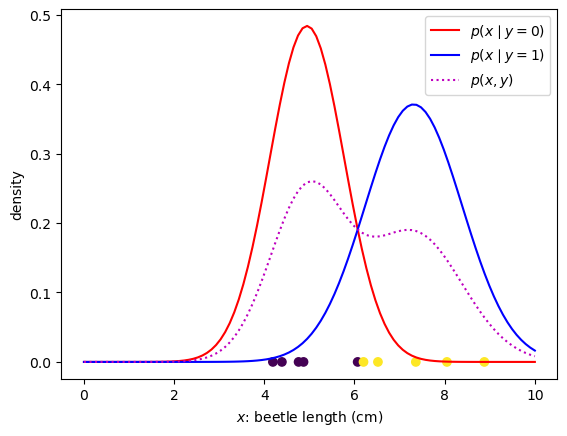

In [12]:
fig = plt.figure()
xx = np.linspace(0, 10, num=100)

plt.plot(xx, p(xx, m[0], s[0]), 'r-', label="$p(x \mid y = 0)$")
plt.plot(xx, p(xx, m[1], s[1]), 'b-', label="$p(x \mid y = 1)$")
plt.plot(xx, w[0] * p(xx, m[0], s[0]) + w[1] * p(xx, m[1], s[1]), 'm:', label="$p(x,y)$")
plt.legend()
plt.xlabel("$x$: beetle length (cm)")
plt.ylabel("density")
plt.scatter(x, np.zeros_like(x), c=yp, label="beetles");

### Generative Models for Generation

And of course, generative models can be used for generation. 

**Task:** Generate 100 beetles (their lengths and their species label) according to $p(x,y)$ as you have modeled so far.

**Hint:** In the following you will generate beetles of both species, but it should be clear to you (in fact, it would be a slightly easier task), how to generate beetles from a specific species. 

In [13]:
n_gen = 100

# You will need to change this:
x_gen = np.ones(n_gen, dtype=float)
y_gen = np.ones(n_gen, dtype=int)

# YOUR CODE HERE
for i in range(n_gen):
    y_gen[i] = np.random.choice([0, 1], p=w)
    j = y_gen[i]
    x_gen[i] = np.random.normal(loc=m[j], scale=s[j])
for i in range(n_gen):
    print(f"Beetle {i+1}: Length={x_gen[i]}, Species={y_gen[i]}")

Beetle 1: Length=4.933277521082076, Species=0
Beetle 2: Length=3.663378272234073, Species=0
Beetle 3: Length=3.9787321399609503, Species=0
Beetle 4: Length=7.682387856974215, Species=1
Beetle 5: Length=5.707765374842526, Species=0
Beetle 6: Length=8.475348784894514, Species=1
Beetle 7: Length=3.607443727677574, Species=0
Beetle 8: Length=5.875319749070426, Species=1
Beetle 9: Length=6.614214031372423, Species=1
Beetle 10: Length=5.7244065889299875, Species=0
Beetle 11: Length=7.415938312620346, Species=1
Beetle 12: Length=6.281833996100521, Species=1
Beetle 13: Length=6.023038277924953, Species=0
Beetle 14: Length=6.7693480955612575, Species=1
Beetle 15: Length=3.5780638441061248, Species=0
Beetle 16: Length=5.022896569016407, Species=0
Beetle 17: Length=6.987453592829825, Species=1
Beetle 18: Length=6.977952586526169, Species=1
Beetle 19: Length=4.027036108483341, Species=0
Beetle 20: Length=7.342555968015992, Species=1
Beetle 21: Length=7.364075127027923, Species=1
Beetle 22: Length=

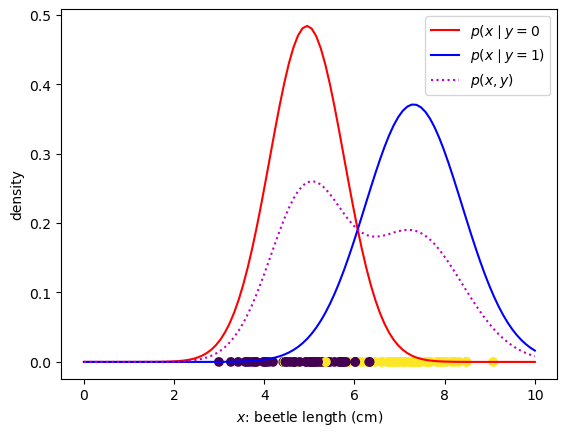

In [14]:
# Let's have a look ...
fig = plt.figure()
xx = np.linspace(0, 10, num=100)

plt.plot(xx, p(xx, m[0], s[0]), 'r-', label="$p(x \mid y = 0$")
plt.plot(xx, p(xx, m[1], s[1]), 'b-', label="$p(x \mid y = 1)$")
plt.plot(xx, w[0] * p(xx, m[0], s[0]) + w[1] * p(xx, m[1], s[1]), 'm:', label="$p(x,y)$")


plt.legend()
plt.xlabel("$x$: beetle length (cm)")
plt.ylabel("density")
plt.scatter(x_gen, np.zeros_like(x_gen), c=y_gen, label="beetles")
plt.show()

### Latent Variables

But suppose that species labels `y` *are not available* in your training data; you only *suspect* they might be comprised of two different species. Gaussian Mixture Models and Expectation Maximization would be an excellent combination here to investigate this question further. 

**Task:** Think about it, keep in mind the lecture material on this! 

**Hint:** It will end up being like a 'soft' and probabilistic version of k-means clustering.

In [15]:
# YOUR CODE HERE
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=2)
gmm.fit(x.reshape(-1, 1))
weights = gmm.weights_
means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
labels = gmm.predict(x.reshape(-1, 1))
print("Estimated Parameters:")
print("Weight of Component 0:", weights[0])
print("Mean of Component 0:", means[0])
print("Standard Deviation of Component 0:", stds[0])
print("Weight of Component 1:", weights[1])
print("Mean of Component 1:", means[1])
print("Standard Deviation of Component 1:", stds[1])

print("\nClassified Labels:")
print(labels)

Estimated Parameters:
Weight of Component 0: 0.6196860662362231
Mean of Component 0: 7.100968125172517
Standard Deviation of Component 0: 1.1000725524957577
Weight of Component 1: 0.3803139337637769
Mean of Component 1: 4.54526863882071
Standard Deviation of Component 1: 0.27401004867445833

Classified Labels:
[1 0 1 1 1 0 0 0 0 0]


## Part 2: genetic algorithms (5 pts)

### 1. Problem setting

You are a big [Corporate and Investment Bank](https://www.investopedia.com/articles/professionals/100215/career-advice-investment-banking-vscorporate-finance.asp) which has many "companies" (their securities: equities, loans, bonds, ...) in its [portfolio](https://www.investopedia.com/terms/p/portfolio.asp).

To satisfy your reglementary obligations, you have to estimate each company's [probability of default](https://en.wikipedia.org/wiki/Probability_of_default): you have probably heard of the "AAA" rating of France (which is treated as a big company) by so-called *rating agencies* (meaning they disclose their ratings), recently downgraded to "AA".

You can view the default of a company as a binary variable $Y$. We're measuring $p(y | x)$ where $x$ are the company's characteristics (turnover, EBITDA, ...).

These *grades* (A, B, C, ...) are then used to assess the *global* quality of a bank's portfolio in many ways:
1. Is it at the brink of insolvency?
(Read: Lehman Brothers)
2. How much should the bank provision for this year's **expected** losses?
(How they do so is out of the scope of the present lab, but it's more or less a big SUMPROD: multiply the probability of default by the outstanding - how much the company owes you - and the "loss given default" - how much you expect to lose if a default happens, e.g. what is left when a bailiff sold the company's furniture).
3. How much would be lost if their is an economic downturn (read: a subprime crisis)?
This is the use case we're interested in today.

In a [stress test](https://en.wikipedia.org/wiki/Stress_test_(financial)), the bank tries to link the quality of its portfolio to macro-economic variables. This is usually done through downgrading the transition matrix.

The transition matrix represents the fraction of companies transitioning from one grade to another from this year to next year.

Take the example of grade "A": we want to estimate how many companies with this grade will fall into grade "B" next year, grade "C", etc.

In [16]:
grades =["A+", "A", "B+", "B", "C+", "C", "C-", "D+", "D", "D-", "E+", "E", "E-"]

In [17]:
initial_per_grade = {'A+': 1000,
                     'A':  2000,
                     'B+': 3000,
                     'B':  4000,
                     'C+': 4500,
                     'C':  5000,
                     'C-': 4500,
                     'D+': 4000,
                     'D':  3000,
                     'D-': 2000,
                     'E+': 1000,
                     'E':  500,
                     'E-': 250}

Let's assume there is no new counterparts, nor any counterpart that gets out by defaulting and / or not having any outstanding. We generate a true transition matrix (which we'll aim at recovering later on!):

In [18]:
true_transition_matrix = pd.DataFrame(
    data=np.random.rand(len(initial_per_grade), len(initial_per_grade)),
    index=initial_per_grade.keys(),
    columns=initial_per_grade.keys())

true_transition_matrix = (true_transition_matrix + 
                          4 * np.eye(true_transition_matrix.shape[0]))
true_transition_matrix = true_transition_matrix.div(true_transition_matrix.sum(axis=1), axis=0)

true_transition_matrix.index.name = "from"
true_transition_matrix.columns.name = "to"

The rows represent the grade "from" which counterparts transition, the columns represent the grade "to" which they transition, *e.g.* in cell $(i, j)$ is the proportion of counterparts in grade $i$ in year Y that have grade $j$ in year Y+1.

In [19]:
true_transition_matrix

to,A+,A,B+,B,C+,C,C-,D+,D,D-,E+,E,E-
from,,,,,,,,,,,,,
A+,0.431505,0.025281,0.008601,0.064045,0.022569,0.067609,0.026199,0.008257,0.037254,0.082408,0.082441,0.087542,0.056289
A,0.083375,0.437274,0.101213,0.011674,0.040398,0.006298,0.006333,0.080271,0.088026,0.005650,0.061191,0.002458,0.075841
B+,0.069761,0.011409,0.459303,0.017260,0.031492,0.040859,0.071903,0.050510,0.092046,0.016919,0.027902,0.073326,0.037309
B,0.008857,0.047081,0.000848,0.380861,0.060761,0.066109,0.041196,0.072450,0.053839,0.063375,0.070102,0.066985,0.067535
C+,0.067947,0.059470,0.015637,0.008388,0.394646,0.073591,0.040917,0.063745,0.017745,0.070968,0.066819,0.035744,0.084383
C,0.065098,0.025632,0.055814,0.057721,0.062166,0.403528,0.005446,0.025846,0.057989,0.046905,0.077411,0.037541,0.078903
C-,0.074667,0.005159,0.001875,0.003102,0.079411,0.011682,0.502013,0.020457,0.088100,0.029601,0.086260,0.006831,0.090842
D+,0.077718,0.021056,0.013645,0.074923,0.034029,0.051294,0.053909,0.388554,0.080912,0.012229,0.062606,0.042088,0.087037
D,0.058352,0.061667,0.053656,0.057928,0.056159,0.042736,0.012334,0.073254,0.409013,0.003459,0.052565,0.073957,0.044919


We will use this matrix to generate data for the subsequent 10 years. Here is the initial distribution rearranged as a row dataframe:

In [20]:
initial_per_grade = pd.DataFrame(
    data=[initial_per_grade.values()],
    columns=initial_per_grade.keys(),
    index=[2000])

In [21]:
initial_per_grade

,A+,A,B+,B,C+,C,C-,D+,D,D-,E+,E,E-
2000,1000,2000,3000,4000,4500,5000,4500,4000,3000,2000,1000,500,250


Generating new years simply means multiplying the year before by the transition matrix:

In [22]:
df_data = [initial_per_grade]
for year in range(2001, 2011):  # we generate 10 years of new data
    df_data.append(pd.DataFrame(
        data=(df_data[-1].values @ true_transition_matrix.values).astype(int),
        columns=initial_per_grade.keys(),
        index=[year]))

df_data = pd.concat(df_data)
df_data.index.name = "year"
df_data.columns.name = "grade"

In [23]:
df_data

grade,A+,A,B+,B,C+,C,C-,D+,D,D-,E+,E,E-
year,,,,,,,,,,,,,
2000,1000,2000,3000,4000,4500,5000,4500,4000,3000,2000,1000,500,250
2001,2473,1878,2369,2746,3430,3366,3376,3083,3197,1933,2657,1669,2567
2002,3039,1786,2221,2517,2985,2849,2948,2800,3079,1934,3214,2210,3155
2003,3252,1731,2179,2511,2803,2692,2786,2704,2979,1950,3396,2458,3290
2004,3329,1701,2161,2536,2729,2647,2725,2668,2925,1964,3454,2570,3316
2005,3356,1685,2151,2555,2700,2634,2702,2653,2899,1973,3471,2620,3318
2006,3365,1677,2145,2566,2688,2631,2693,2647,2887,1978,3476,2642,3316
2007,3367,1673,2141,2571,2683,2630,2690,2644,2882,1980,3477,2651,3315
2008,3367,1671,2139,2573,2681,2630,2688,2642,2879,1981,3477,2655,3314


Let's pivot this data so that for each year we have the number of counterparts and their proportion that year per grade:

In [24]:
df_data = pd.melt(df_data.reset_index(), id_vars='year', value_vars=df_data.columns.to_list())

In [25]:
df_data

,year,grade,value
0,2000,A+,1000
1,2001,A+,2473
2,2002,A+,3039
3,2003,A+,3252
4,2004,A+,3329
...,...,...,...
138,2006,E-,3316
139,2007,E-,3315
140,2008,E-,3314
141,2009,E-,3313


Let's use a random initial transition matrix:

In [26]:
initial_transition_matrix = np.random.rand(*true_transition_matrix.shape)
initial_transition_matrix = pd.DataFrame(initial_transition_matrix,
                                         index=true_transition_matrix.index.copy(),
                                         columns=true_transition_matrix.columns.copy())
initial_transition_matrix = initial_transition_matrix.div(initial_transition_matrix.sum(axis=1), axis=0)

In [27]:
initial_transition_matrix

to,A+,A,B+,B,C+,C,C-,D+,D,D-,E+,E,E-
from,,,,,,,,,,,,,
A+,0.051830,0.123928,0.104774,0.036765,0.064695,0.075291,0.052686,0.133669,0.080315,0.021706,0.108796,0.100851,0.044694
A,0.090827,0.024301,0.167016,0.121770,0.061606,0.083636,0.127953,0.018412,0.160771,0.000629,0.045332,0.043984,0.053764
B+,0.063486,0.095363,0.098193,0.017491,0.120063,0.108869,0.008667,0.015400,0.107917,0.065272,0.025211,0.138680,0.135388
B,0.145784,0.098840,0.061870,0.022955,0.075172,0.132936,0.014165,0.052918,0.080322,0.145900,0.047840,0.007030,0.114268
C+,0.058166,0.039001,0.032559,0.115149,0.100890,0.093965,0.108258,0.052066,0.057805,0.098561,0.064203,0.091223,0.088155
C,0.116594,0.092184,0.038721,0.059847,0.044603,0.110681,0.061646,0.120693,0.107822,0.061591,0.030811,0.098579,0.056228
C-,0.055341,0.037282,0.147155,0.035805,0.156504,0.026388,0.021281,0.129718,0.010396,0.018523,0.134275,0.092574,0.134760
D+,0.131690,0.058630,0.033442,0.026700,0.142903,0.008460,0.152228,0.068007,0.150154,0.069125,0.049974,0.035575,0.073112
D,0.122539,0.081503,0.000946,0.032879,0.073474,0.071274,0.130371,0.140020,0.019572,0.092189,0.057343,0.037139,0.140750


### 2. Fit criteria

In genetics algorithms, a feasible solution is called an "individual". These algorithms revolve around the idea that individuals evolve from some initial(ization) imperfect individual to a perfect(ly adapted to its environment) individual.

We will use the imperfect transition matrix defined above as our initialization of an individual:

In [28]:
def init(individual):
    trans_matrix_cpy = initial_transition_matrix.copy()
    # Since the algorithm will run in parallel with several initializations,
    # we will run init() several times... and want it to use slightly different
    # initial individuals, hence the random component below
    trans_matrix_cpy = trans_matrix_cpy + 0.1 * np.random.rand(*trans_matrix_cpy.shape)
    individual[:] = trans_matrix_cpy.div(trans_matrix_cpy.sum(axis=1), axis=0).values.flatten()
    return individual

#### Fitness (or loss)

Subsequently, we have to come up with a loss criterion to quantitatively assess what is a good fitness. Unsurprisingly we rely on squared error: we apply the transition matrix year after year and sum the errors made each year.

In [29]:
initial_year = df_data["year"].min()
first_year = df_data[df_data["year"] == initial_year]
other_years = df_data[df_data["year"] > initial_year]["year"].unique()

#### Absolute error

The following function takes the proposed transition matrix `transition_matrix`, applies it to the first year iteratively, and computes the squared error made by projecting the percentage of companies in each grade.

In [30]:
def abs_error(transition_matrix: np.ndarray, ptfl_data: pd.DataFrame, other_years: list):
    initial_M = transition_matrix.reshape((13, 13))
    current_M = initial_M.copy()
    error = 0
    for year in sorted(other_years):
        current_year = ptfl_data[ptfl_data["year"] == year]
        df_estimated = pd.DataFrame(
            {"grade": grades,
             "value_estimated": (first_year["value"].values @ current_M).astype(int)})
        current_M = current_M @ initial_M
        result = df_estimated.merge(current_year, how="left", on="grade")
        error += np.abs(result["value_estimated"] - result["value"]).sum()
    return error

In [31]:
first_year["value"].values

array([1000, 2000, 3000, 4000, 4500, 5000, 4500, 4000, 3000, 2000, 1000,
        500,  250])

In [32]:
first_year["value"].values

array([1000, 2000, 3000, 4000, 4500, 5000, 4500, 4000, 3000, 2000, 1000,
        500,  250])

The initial one should be relatively bad:

In [33]:
abs_error(initial_transition_matrix.values.flatten(), df_data, other_years)

61856

The true one should conduct to compounding ronding errors only (so much lower):

In [34]:
abs_error(true_transition_matrix.values.flatten(), df_data, other_years)

305

#### Smoothness / penalties

We also want to enforce some idea of smoothness: a very high penalty if the maximum probability in the transition matrix is **not** on the diagonal.
Also, we want a "triangular" shape, i.e. we we want a decrease in the transition probability when we get further from the grade.
Example: companies currently in Grade B will stay B with 70 % chance, go A with 10 % chance, go C with 10 % chance, D with 5 % chance, etc.

Think of this as the equivalent of ridge/lasso in the context of genetic algorithms.

In [35]:
def smoothness(transition_matrix: pd.DataFrame):
    ## Let's put a 3000 penalty if the max is not on the diagonal
    argmaxes = np.argmax(transition_matrix.reshape((13, 13)), axis=1)
    smoothness_metric = 3000 * sum(argmaxes != np.array(list(range(13))))
    return smoothness_metric

The initial one should be pretty bad:

In [36]:
smoothness(initial_transition_matrix.values.flatten())

39000

The true one should be good:

In [37]:
smoothness(true_transition_matrix.values.flatten())

0

Let's wrap those two metrics in `the_fitness` function (which will be part of a class, hence the presence of `self`).

In [38]:
def the_fitness(self):
    distance_metric = abs_error(np.array(self), df_data, other_years)
    smoothness_metric = smoothness(np.array(self))
    return distance_metric, smoothness_metric

### 3. Proposed resolution

Similar to the computer scientists who like to brag about the "inspiration" of human neurons for neural networks, some have taken inspiration from Darwinism and its evolution theory to come up with a family of algorithms: genetic algorithms.

#### Individuals / chromosomes

A **solution** to a problem is represented by an **individual**. In our case, that's the transition matrix.

#### Population

The point of evolutionary methods is to try out many solutions to a problem, but still far less than the total number of possible solutions (the search space).

**A population is a collection of individuals.**

#### Genes

Much like the weights in a neural network, **genes are the real values we try to optimize**.

In our example, that's each transition probability (each entry in the transition matrix).

#### Putting it all together

Let's look at the big picture; we have:
* a fitness criterion that we wish to maximize, and which is not convex (no analytical solution);
* a search space that is too large to compute the fitness of all possible solutions;
* a population of "random" initial individuals (well, only 1 for now - which are not particularly good).

How does nature do?

1. Select (the fittest);
1. Mate (sometimes called "crossover" not to hurt anyone's mind);
1. Mutate.

Applying genetic algorithms successfully is thus all about coming up with good selection, mating (crossover) and mutation routines.

We will use the [DEAP library](https://deap.readthedocs.io/en/master/). You can have a look at its selection, mating and mutation implemented routines on [this page](https://deap.readthedocs.io/en/master/api/tools.html).

In [39]:
from deap import creator, base, tools

In [40]:
# We will "create" our own algorithm and use the "Fitness" and "Individual" concepts.
creator.create("Fitness",
               base.Fitness,
               weights=(-1, -1))

creator.create("Individual",
               np.ndarray,
               fitness=creator.Fitness)

In [41]:
# We will use a custom Individual class.
class Individual(creator.Individual):

    def __init__(self, *args, **kwargs):
        super(Individual, self).__init__(*args, **kwargs)

    def the_fitness(self):
        distance_metric, smoothness_metric = the_fitness(self)
        return distance_metric, smoothness_metric

In [42]:
# To be able to reproduce our results
state = np.random.RandomState(204)

In [43]:
# A facility to evaluate individuels
def evaluate(ind, *args, **kwargs):
    return ind.the_fitness(*args, **kwargs)

# To keep track of fitness values
def statistics(ind):
    return ind.fitness.values

In [44]:
# We use a DEAP "toolbox".
toolbox = base.Toolbox()

# A random number sampled uniformly between 0 and 1.
toolbox.register("attr_bool",
                 state.uniform,
                 0,
                 1)

# We register what an individual is and how to initialize it.
# We will override this initialization afterwards.
toolbox.register("individual",
                 tools.initRepeat,
                 Individual,
                 toolbox.attr_bool,
                 n=13 * 13)

# A population is a collection of individuals.
toolbox.register("population",
                 tools.initRepeat,
                 list,
                 toolbox.individual)

# Our custom init function.
toolbox.register("initialization", init)

# Our evaluation function.
toolbox.register("evaluate", evaluate)

# The selection mechanism (see below).
toolbox.register("select", tools.selNSGA2)

# The map function will be used to parallelize the evaluation of the fitness functions.
toolbox.register("map", multiprocessing.Pool(processes=4).map)

We have introduced a level of difficulty: we have two fitness functions (`squared_error` and `smoothness`). We **could** mix them into a single value, which is often done in practice.

However, for the purpose of this lab, we will use the [NSGA-II algorithm](http://repository.ias.ac.in/83498/1/2-a.pdf) (Elitist Non-dominated Sorting Genetic Algorithm) which deals with multi-objectives.

#### Selection

A solution $x_1$ is said to dominate another solution $x_2$ if both the following conditions are true:
* The solution $x_1$ is not worse than $x_2$ in all objectives, or $f_j(x_1)$ is better than $f_j(x_2)$ for all $j
\in \{1, 2, . . . , M\}$ where $f_j$ is the $j$-th objective function and $M$ is the number of objectives ($M=2$ here).

* The solution $x_1$ is strictly better than $x_2$ in at least one objective, or $f_j(x_1)$ is better than $f_j(x_2)$ for at least one $j \in \{1, 2, . . . , M\}$.

We perform "non-dominated sorting" to the population: for example, the "Rank 3" (green) individuals below are dominated by an individual in "Rank 2" (in red - try to spot which one), while the "Rank 1" (blue) individuals aren't dominated by any other individual.

The "ranks" below are [Pareto fronts](https://en.wikipedia.org/wiki/Pareto_efficiency).

![Pareto fronts](https://www.researchgate.net/profile/Zbynek-Raida/publication/260115283/figure/fig2/AS:669059364450313@1536527591578/Non-dominated-sorting-to-advancing-fronts.png)

#### Crowding distance (sorting)

The diversity among non-dominated solutions is introduced by using the crowding comparison procedure.

In a given rank / Pareto front, we search for the largest "cuboid" (remember there can be an arbitrary number $M$ of fitness functions) around a given solution in which there are no other solutions (we can set it to $\infty$ for point in the "boundary", i.e. with the minimal / maximal values of each fitness function).

In what follows, we will prefer solutions with large crowding distances, which guarantees some diversity (imagine what happens if many solutions are close one-another).

![Crowding distance](https://www.researchgate.net/profile/Sahar-Taslimi-Taleghani/publication/261031359/figure/fig2/AS:529861821566981@1503340310654/Calculation-of-crowding-distance-in-NSGAII-algorithm.png)

#### Wrapping up

Suppose we have a population of 30 individuals with 3 fronts of 7, 8 and 15 individuals respectively.

An NSGA-II selection of, say, 20 individuals, will take all 7 individuals from Rank 1, all 8 individuals from Rank 2, and the 5 individuals from Rank 3 with the largest crowding distance. The 10 remaining individuals (from Rank 3) are rejected. All remaining individuals form the "candidates" for the next generation and are sorted by their crowding distance.

![NSGA-II Selection](https://i0.wp.com/oklahomaanalytics.com/wp-content/uploads/2017/10/fig4.png?resize=768%2C418)

#### Mate / crossover

When two individuals mate / two chromosomes are "crossed over", we simply "mix" their genes at random cut-points. We will use, as exemplified below, a ["two point crossover"](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint) where the two cut-points are chosen randomly.

In [45]:
toolbox.register("mate", tools.cxTwoPoint)

![Two points crossover](https://upload.wikimedia.org/wikipedia/commons/thumb/c/cd/TwoPointCrossover.svg/226px-TwoPointCrossover.svg.png)

#### Mutation

The idea behind mutation is to choose and individual's genes with some probability (that can itself be constant or decaying) and modify their values. Here, we choose some random noise (you can change this function to see how it influences the results). 

In [46]:
def mutation(individual,
             indpb_alpha,
             indpb_beta,
             sigma,
             gen=0):
    """
    Perform mutation: we add random noise (with standard deviation `sigma`) to an individual's genes with some
        probability (see below).

    :param indpb_alpha: the probability of a given individual to undergo mutation (for the first generation).
    :param indpb_beta: the rate of exponential decay of the probability to undergo mutation w.r.t. the generation. 
    """
    # Decide whether to mutate
    indpb = indpb_alpha * np.exp(-indpb_beta * gen)

    for idx, gene in enumerate(individual):
        if state.uniform(0, 1) < indpb:
            individual[idx] = min(max(gene + state.normal(0, sigma), 0.0), 1)

    # Renormalize the matrix
    ind_pandas = pd.DataFrame(individual.reshape((13, 13)))
    ind_pandas = ind_pandas.div(ind_pandas.sum(axis=1), axis=0)
    individual[:] = ind_pandas.values.flatten()
    return individual

In [47]:
# Registering our mutation function.
toolbox.register("mutate", mutation)

## Running the algorithm

These are the hyper-parameters you'll have to tweak:

In [48]:
# This controls the population size, i.e. the number of individuals (== solutions) to consider at each generation.
popsize = 32
# This controls the number of generations, i.e. the number of iterations of the algorithm.
nb_gen = 480
# This controls the mating probability, i.e. the probability for a given pair of individuals to mate.
crossover_probability = 0.825
# This controls the mutation probability of the first generation
indpb_alpha=0.8
# The subsequent generations will mutate with a decaying probability
indpb_beta=0.025
# Random noise added when undergoing mutation
sigma=0.17

# YOUR CODE HERE

We will keep track of all individuals (in all generations) in `all_inds`.

We will keep a "Hall of Fame" of the best individuals irrespective of the generation, with ParetoFront (keeping track of all Pareto Fronts).

In [49]:
all_inds = []
generations = [i for j in range(popsize) for i in range(nb_gen)]
fitness = np.zeros((nb_gen * popsize, 2))
hof = tools.ParetoFront(similar=np.array_equal)

In [50]:
# For each generation, compute the mean, min, max values of all fitness functions.
stats = tools.Statistics(key=statistics)
stats.register("avg", np.mean, axis=0)
stats.register("min", np.min, axis=0)
stats.register("max", np.max, axis=0)

In [51]:
# The `logbook` will contain this statistics
logbook = tools.Logbook()
logbook.header = ['gen', 'nevals'] + stats.fields

As promised, we override the random initialization of individuals (since they won't be respecting the condition that the columns sum to 1).

In [52]:
pop = toolbox.population(n=popsize)
for ind in pop:
    ind = init(ind)

In [53]:
pd.DataFrame(np.array(ind).reshape((13, 13)))

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.078753,0.119292,0.119697,0.064153,0.040009,0.045437,0.083756,0.087049,0.048690,0.071131,0.110579,0.101338,0.030116
1,0.090163,0.019251,0.130044,0.072473,0.073701,0.053700,0.096265,0.054207,0.140218,0.053053,0.063241,0.080190,0.073494
2,0.067984,0.111533,0.085226,0.044275,0.117343,0.085072,0.013285,0.055800,0.071354,0.093848,0.030263,0.109977,0.114039
3,0.120671,0.118142,0.069415,0.040785,0.084137,0.102803,0.012638,0.044615,0.086826,0.113371,0.040658,0.067180,0.098759
4,0.090058,0.036291,0.036944,0.072398,0.106737,0.061111,0.089575,0.047092,0.074352,0.109097,0.093008,0.113466,0.069870
5,0.095027,0.095678,0.072309,0.081359,0.068732,0.063248,0.051456,0.104576,0.102182,0.047950,0.060135,0.088157,0.069192
6,0.063438,0.025520,0.138195,0.066098,0.091801,0.072396,0.020776,0.123675,0.027542,0.061582,0.136660,0.062419,0.109898
7,0.094009,0.086843,0.024438,0.042588,0.137030,0.031259,0.138018,0.083113,0.110631,0.094922,0.039419,0.049152,0.068578
8,0.095118,0.101159,0.051361,0.023925,0.101552,0.098713,0.120386,0.086019,0.035980,0.097307,0.050218,0.043410,0.094852
9,0.046578,0.117230,0.047702,0.088786,0.093524,0.076205,0.056839,0.119477,0.104536,0.056070,0.067445,0.065150,0.060458


#### Evaluation

Let's evaluate the fitness of this first generation:

In [54]:
# Evaluate the entire population
fitnesses = [toolbox.evaluate(ind) for ind in pop]
for ind, fit in zip(pop, fitnesses):
    ind.fitness.values = fit
    fitness[len(all_inds), :] = fit
    all_inds.append(ind)

In [55]:
fitnesses[:10]

[(56142, 36000),
 (54256, 39000),
 (52317, 39000),
 (60177, 39000),
 (54492, 39000),
 (52873, 39000),
 (58679, 39000),
 (55148, 36000),
 (53737, 39000),
 (57499, 39000)]

#### Selection

In [56]:
# Selection (it's more about setting the crowding distance, since we retain everyone)
pop = toolbox.select(pop, len(pop))

#### Logging the performance

In [57]:
# Performance of the first population
record = stats.compile(pop) if stats else {}
logbook.record(gen=0, nevals=popsize, **record)
print(logbook.stream)
hof.update(pop)

gen	nevals	avg                    	min            	max            
0  	32    	[58257.0625 38343.75  ]	[50848. 33000.]	[67975. 39000.]


#### Iterating over generations

In [58]:
# Iterating over generations
for gen in range(1, nb_gen):
    # Selection
    offspring = toolbox.select(pop, len(pop))
    offspring = [toolbox.clone(ind) for ind in offspring]

    # Mating / Mutations
    for ind1, ind2 in zip(offspring[::2], offspring[1::2]):
        if state.uniform() <= crossover_probability:
            toolbox.mate(ind1, ind2)

        toolbox.mutate(ind1, indpb_alpha, indpb_beta, sigma, gen=gen)
        toolbox.mutate(ind2, indpb_alpha, indpb_beta, sigma, gen=gen)
        del ind1.fitness.values, ind2.fitness.values

    # Evaluations
    # Re-evaluate individuals which have mated or mutated
    invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit
        fitness[len(all_inds), :] = fit
        all_inds.append(ind)

    # Selection is done on population and its offspring
    pop = toolbox.select(pop + offspring, popsize)

    # Stats
    record = stats.compile(pop)
    logbook.record(gen=gen, nevals=len(invalid_ind), **record)
    hof.update(pop)
    if gen > 0 and ((gen % 10) == 0):
        print("Generation : {} of {}".format(gen, nb_gen))
        print(logbook.stream)

Generation : 10 of 480
1  	32    	[77457.15625 35625.     ]	[50848. 30000.]	[153869.  39000.]
2  	32    	[76166.8125 35437.5   ]  	[50848. 30000.]	[158262.  39000.]
3  	32    	[77381.75 35156.25]      	[50848. 30000.]	[158262.  39000.]
4  	32    	[78012.40625 34406.25   ]	[50848. 27000.]	[158262.  39000.]
5  	32    	[78131.8125 34031.25  ]  	[50848. 27000.]	[153869.  39000.]
6  	32    	[74870.3125 34031.25  ]  	[50848. 27000.]	[132045.  39000.]
7  	32    	[73117.78125 34031.25   ]	[47867. 27000.]	[131292.  39000.]
8  	32    	[72596.3125 33656.25  ]  	[47867. 27000.]	[127795.  39000.]
9  	32    	[72367.9375 33281.25  ]  	[47867. 27000.]	[144329.  39000.]
10 	32    	[72186.3125 33093.75  ]  	[47867. 27000.]	[144329.  39000.]
Generation : 20 of 480
11 	32    	[71181.78125 32906.25   ]	[47867. 24000.]	[127795.  39000.]
12 	32    	[70893.625 32812.5  ]    	[47867. 24000.]	[127795.  39000.]
13 	32    	[70611.53125 32718.75   ]	[47867. 24000.]	[127405.  39000.]
14 	32    	[70173.75 32718.75] 

### Results

Let's plot the average (in the population) value of the fitness functions w.r.t. the generation):

In [59]:
# Stats per generations
df_record = pd.DataFrame(logbook)

# Performances per individual
metrics = [(0, "Absolute Error"),
           (1, "Smoothness")]

for idx, name in metrics:
    # Evolution of the score per generation
    hover0 = HoverTool()
    p = figure(title="Objective function {} w.r.t. the generation".format(name),
               width=700,
               height=400,
               tools=["pan", "wheel_zoom", "box_zoom", "save", "reset", hover0])
    p.grid.grid_line_alpha = 0.4
    p.xaxis.axis_label = 'Generation'
    p.yaxis.axis_label = name
    p.line(df_record["gen"],
           [x[idx] for x in df_record["avg"]],
           color=viridis(len(metrics) + 1)[idx], name="hover")

    # Bollinger shading glyph
    upperband = [x[idx] for x in df_record["max"]]
    lowerband = [x[idx] for x in df_record["min"]]
    x_data = df_record["gen"]

    # Define Bollinger Bands
    band_x = np.append(x_data, x_data[::-1])
    band_y = np.append(lowerband, upperband[::-1])
    p.patch(band_x, band_y, color=viridis(len(metrics) + 1)[idx],
            fill_alpha=0.2)
    show(p)

We select the first Pareto front and output the value of their fitness functions:

In [60]:
best = tools.sortLogNondominated(pop, 1, first_front_only=True)

In [61]:
for indivi in best:
    print(indivi.fitness)

(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(10695.0, 15000.0)
(12825.0, 12000.0)
(12825.0, 12000.0)


As they are sorted in lexicographical order (first fitness function in ascending order), let's show the last individual (which is the best solution w.r.t. the second fitness function).

In [62]:
pd.DataFrame(best[-1].reshape((13, 13)), index=grades, columns=grades)

,A+,A,B+,B,C+,C,C-,D+,D,D-,E+,E,E-
A+,0.257511,0.000000,0.000000,0.000000,0.140056,0.107603,0.163076,0.065693,0.036811,0.000000,0.169531,0.059719,0.000000
A,0.182451,0.000000,0.000000,0.046847,0.000000,0.180724,0.000000,0.000000,0.043633,0.000514,0.012196,0.085944,0.447692
B+,0.165316,0.000000,0.183218,0.028071,0.082426,0.000000,0.141535,0.009858,0.164605,0.073785,0.079102,0.000000,0.072083
B,0.000000,0.097675,0.000000,0.203722,0.052713,0.109946,0.000000,0.000000,0.099239,0.045208,0.173040,0.074803,0.143655
C+,0.000000,0.000000,0.172397,0.191036,0.000000,0.000000,0.178192,0.000000,0.255373,0.000000,0.099696,0.103307,0.000000
C,0.062988,0.160719,0.098110,0.028281,0.084818,0.321190,0.000000,0.243895,0.000000,0.000000,0.000000,0.000000,0.000000
C-,0.000000,0.024621,0.000000,0.000000,0.101977,0.136232,0.191616,0.101075,0.034183,0.188700,0.042885,0.178711,0.000000
D+,0.197770,0.030784,0.000000,0.208820,0.114627,0.009129,0.039104,0.000000,0.190421,0.032835,0.037754,0.138754,0.000000
D,0.000000,0.000000,0.034781,0.030891,0.196467,0.021169,0.032797,0.166493,0.072823,0.000000,0.113648,0.039493,0.291438
D-,0.159386,0.153207,0.000000,0.061799,0.000000,0.000000,0.109576,0.087052,0.000000,0.206667,0.057191,0.050246,0.114876


### Your turn

Go back and try to modify `popsize`, `nb_gen`, `crossover_probability`, `indpb_alpha`, `indpb_beta` and `sigma`: can you improve the current solution? Converge faster?

Uncomment the cell below to get this lab's bonus.